In [47]:
%reload_ext autoreload
%autoreload 2

# %matplotlib qt

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import sklearn
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [2]:
# TODO
# 1.1. include additional AlignmentModel methods stored in extra class in base model

# Basic alignment_comparison Analyses (or maybe for alignment_stats):
# - compare initial to final alignment...
# - compare initial alignment to delta weight norm...
# - observe alignment of delta weight
# - compare alignment to outgoing delta weight norm!

# Eigenfeature analyses:
# done: - start by just looking at amplitude of activity on each eigenvector within each layer
# done: - Determine contribution of each eigenfeature on performance with a eigenvector dropout experiment
# - Measure beta_adversarial (figure out how adversarial examples map onto eigenvectors)

# forward_eigenvector_dropout is slow... maybe because cpu->gpu overhead? 

# Consider Valentin's idea about measuring an error threshold given signal and noise for a given level of alignment
# e.g. plot a 2d heatmap comparing the noise amplitude and the average alignment
# and then think about how to apply this to network design...

# convert batch_cov to allow for batch_corr too (and make it "smart" with zero-var handling)
# integrate batched alignment into pipeline  (there's test code in the tests directory)

In [9]:
model_name = 'CNN2P2'
dataset_name = 'MNIST'

net = get_model(model_name, build=True, dataset=dataset_name, dropout=0.0, ignore_flag=False)
net.to(DEVICE)

loader_parameters = dict(
    shuffle=True,
)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, loader_parameters=loader_parameters, device=DEVICE)

In [52]:
# test "alignment" metric of Maennel
def metric(data, weight):
    # data is (batch, D)
    # weight is (M, D)
    # measures  sum_i sqrt((vi'Svi).(vi'S-1vi)) where S is W'W and vi are eigenvectors of D'D
    S = torch.cov(weight.T)
    Sinv = torch.inverse(S)
    _, _, v = torch.linalg.svd(data, full_matrices=False)
    upper = torch.sum((v @ S) * v, dim=1)
    lower = torch.sum((v @ Sinv) * v, dim=1)
    return torch.sum(torch.sqrt(upper/lower)) - 1

B, M, D = 1000, 50, 100
k = min(B, D)

data = torch.normal(0, 1, (B, D))

U, S, Vt = torch.linalg.svd(data, full_matrices=False)
w_mix = torch.linalg.qr(torch.normal(0, 1, (D, M)))[0].T
weight = w_mix @ torch.diag(S) @ Vt

weight_aligned = Vt

# weight = torch.normal(0, 1, (M, D))
metric(data, weight)

tensor(nan)

In [43]:
w_mix.shape

torch.Size([100, 50])

In [16]:
weights = net.get_alignment_weights()
print([w.shape for w in weights])

def get_invar(inputs_to_layers, weights):
    invar = []
    for i, w in zip(inputs_to_layers, weights):
        a = torch.matmul(i, w.T)
        invar.append(torch.var(a, dim=0))
    return invar

def get_outvar(outputs_from_layers):
    return [torch.var(o, dim=0) for o in outputs_from_layers]

inputs = []
for batch in dataset.test_loader:
    image, label = dataset.unwrap_batch(batch)
    inputs.append(image)
inputs = torch.cat(inputs, dim=0)

whole = True
with torch.no_grad():
    if whole:
        inputs_to_layers = net.get_layer_inputs(inputs, precomputed=False)
        outputs_from_layers = net.get_layer_outputs(inputs, precomputed=True)
        alignment = net.measure_alignment(inputs, precomputed=True)
        inner_variance = get_invar(inputs_to_layers, weights)
        outer_variance = get_outvar(outputs_from_layers)

    else:
        alignment = []
        inner_variance = []
        outer_variance = []
        for batch in dataset.test_loader:
            images, label = dataset.unwrap_batch(batch)
            out = net(images, store_hidden=True)
            inputs_to_layers = net.get_layer_inputs(images, precomputed=True)
            outputs_from_layers = net.get_layer_outputs(images, precomputed=True)
            alignment.append(net.measure_alignment(images, precomputed=True))
            inner_variance.append(get_invar(inputs_to_layers, weights))
            outer_variance.append(get_outvar(outputs_from_layers))

        alignment = [torch.stack(a) for a in utils.transpose_list(alignment)]
        inner_variance = [torch.stack(iv) for iv in utils.transpose_list(inner_variance)]
        outer_variance = [torch.stack(ov) for ov in utils.transpose_list(outer_variance)]

[torch.Size([100, 784]), torch.Size([100, 100]), torch.Size([50, 100]), torch.Size([10, 50])]


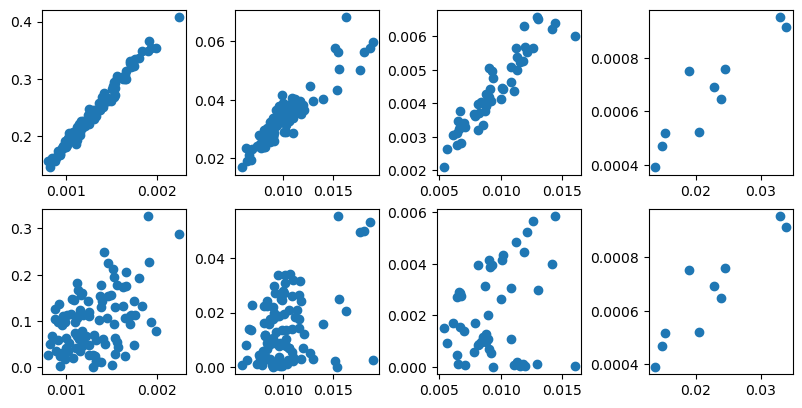

In [41]:
num_layers = len(alignment)

plt.close('all')
fig, ax = plt.subplots(2, num_layers, figsize=(2*num_layers, num_layers), layout='constrained')
for ii, (a, iv, ov) in enumerate(zip(alignment, inner_variance, outer_variance)):
    ax[0, ii].scatter(a.cpu().numpy(), iv.cpu().numpy())
    ax[1, ii].scatter(a.cpu().numpy(), ov.cpu().numpy())
plt.show()